In [1]:
from sklearn import preprocessing
import os
import datetime
import IPython
import IPython.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("preparedAndCleanedData.xlsx")

In [3]:
#df.replace(0,np.nan, inplace=True)

In [4]:
df.head()

,date,tests_per_case,new_vaccinations,Treatment and management of COVID-19: (Ireland),Hand sanitizer: (Ireland),Face mask: (Ireland),reproduction_rate,new_cases_smoothed
0,2020-03-15,0.0,0,1,68,18,2.51,15.714
1,2020-03-16,0.0,0,2,38,18,2.59,21.143
2,2020-03-17,0.0,0,2,38,18,2.70,27.000
3,2020-03-18,0.0,0,2,38,18,2.78,35.571
4,2020-03-19,0.0,0,2,38,18,2.84,73.429


In [5]:
date_time = pd.to_datetime(df.pop('date'), format='%d-%m-%Y')

In [6]:
#split the data 
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
scaler = preprocessing.StandardScaler(with_mean=False).fit(train_df)

In [8]:
df.columns

Index(['tests_per_case', 'new_vaccinations',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'reproduction_rate', 'new_cases_smoothed'],
      dtype='object')

In [9]:
train_scaled = scaler.transform(train_df.to_numpy())

In [10]:
train_scaled = pd.DataFrame(train_scaled,columns=['tests_per_case', 'new_vaccinations',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'reproduction_rate', 'new_cases_smoothed'])

In [11]:
val_scaled = scaler.transform(val_df.to_numpy())

In [12]:
val_scaled = pd.DataFrame(val_scaled,columns=['tests_per_case', 'new_vaccinations',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'reproduction_rate', 'new_cases_smoothed'])

In [13]:
test_scaled = scaler.transform(test_df.to_numpy())

In [14]:
test_scaled = pd.DataFrame(test_scaled,columns=['tests_per_case', 'new_vaccinations',
       'Treatment and management of COVID-19: (Ireland)',
       'Hand sanitizer: (Ireland)', 'Face mask: (Ireland)',
       'reproduction_rate', 'new_cases_smoothed'])

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_scaled=train_scaled, val_scaled=val_scaled, test_scaled=test_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_scaled = train_scaled
    self.val_scaled = val_scaled
    self.test_scaled = test_scaled

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_scaled.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [16]:
window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=['new_cases_smoothed'])

window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['new_cases_smoothed']

In [17]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
train_scaled.shape

(490, 7)

In [19]:
# Stack three slices, the length of the total window.
sample_window = tf.stack([np.array(train_scaled[:window.total_window_size]),
                           np.array(train_scaled[50:50+window.total_window_size]),
                           np.array(train_scaled[100:100+window.total_window_size]),
                           np.array(train_scaled[150:150+window.total_window_size]),
                           np.array(train_scaled[200:200+window.total_window_size]),
                           np.array(train_scaled[250:250+window.total_window_size]),])

sample_inputs, sample_labels = window.split_window(sample_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {sample_window.shape}')
print(f'Inputs shape: {sample_inputs.shape}')
print(f'Labels shape: {sample_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (6, 8, 7)
Inputs shape: (6, 7, 7)
Labels shape: (6, 7, 1)


In [20]:
window.sample = sample_inputs, sample_labels

In [21]:
def plot(self, model=None, plot_col='new_cases_smoothed', max_subplots=6):
  inputs, labels = self.sample
  plt.figure(figsize=(20, 20))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('new_cases_smoothed')

WindowGenerator.plot = plot

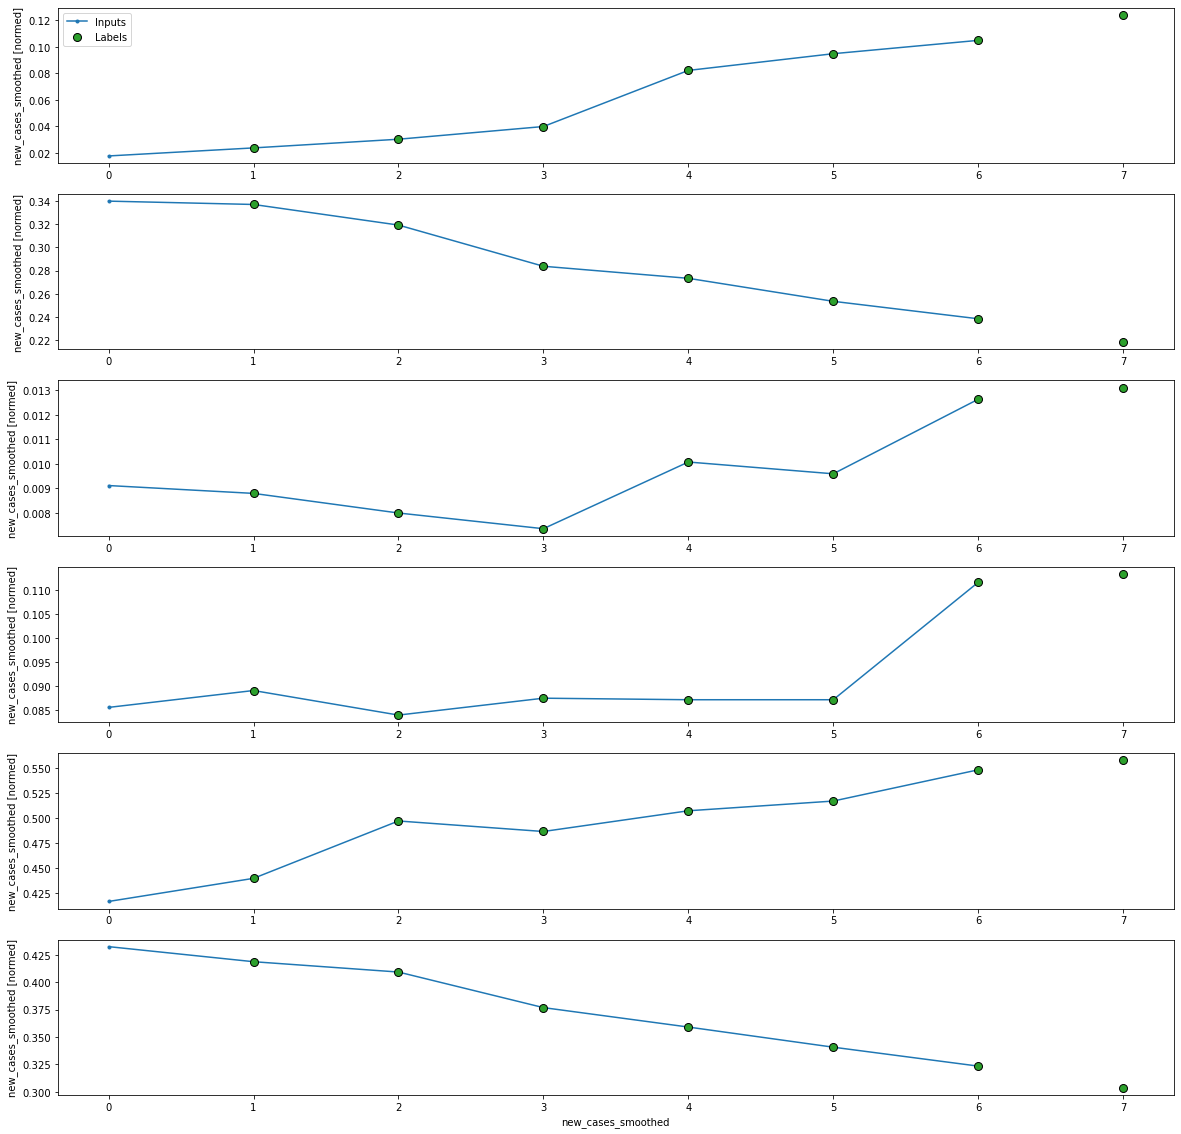

In [22]:
window.plot()

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [24]:
@property
def train(self):
  return self.make_dataset(self.train_scaled)

@property
def val(self):
  return self.make_dataset(self.val_scaled)

@property
def test(self):
  return self.make_dataset(self.test_scaled)

@property
def sample(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_sample', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.sample = sample

In [25]:
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [26]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [27]:
baseline = Baseline(label_index=column_indices['new_cases_smoothed'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(window.val)
performance['Baseline'] = baseline.evaluate(window.test, verbose=0)

5/5 [==============================] - 1s 3ms/step - loss: 0.0184 - mean_absolute_error: 0.0846


In [28]:
from tensorflow.keras import layers

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(256, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
    ])

In [30]:
print('Input shape:', window.sample[0].shape)
print('Output shape:', lstm_model(window.sample[0]).shape)

Input shape: (32, 7, 7)
Output shape: (32, 7, 1)


In [31]:
history = compile_and_fit(lstm_model, window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(window.val)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)


5/5 [==============================] - 0s 6ms/step - loss: 0.0270 - mean_absolute_error: 0.0957


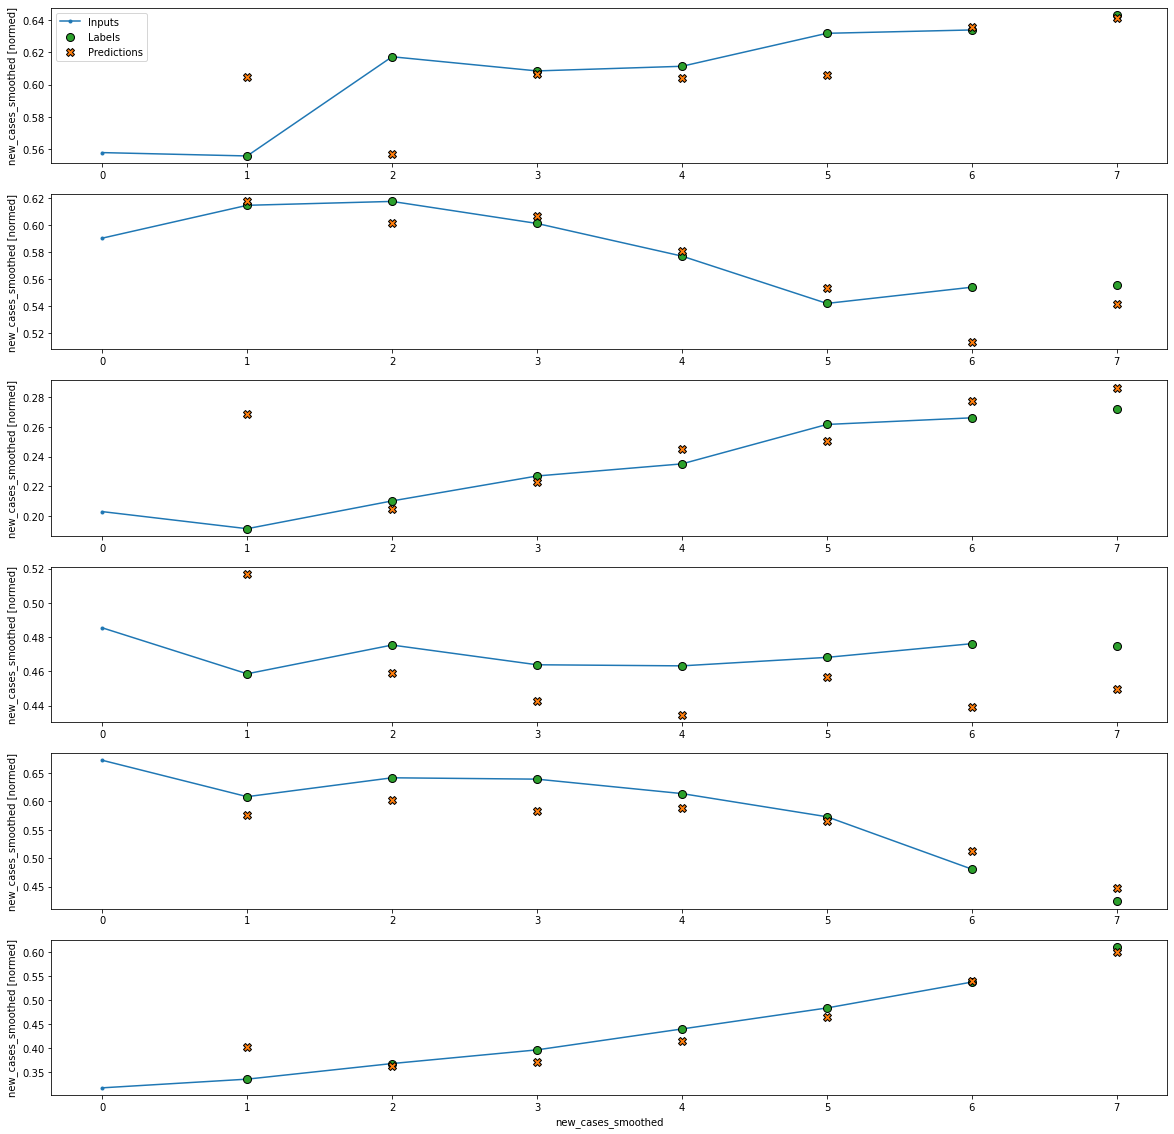

In [32]:
window.plot(lstm_model)

In [33]:
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 256)            270336    
                                                                 
 dense (Dense)               (None, 7, 1)              257       
                                                                 
Total params: 270,593
Trainable params: 270,593
Non-trainable params: 0
_________________________________________________________________
None


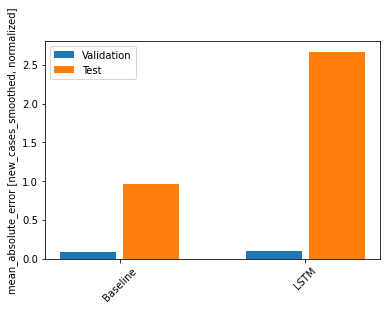

In [34]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [new_cases_smoothed, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [35]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.9654
LSTM        : 2.6723


In [ ]:
#https://github.com/search?l=Python&q=time+series+covid+prediction&type=Repositories